In [0]:
import numpy as np
import math


In [0]:
# Upload the squared image from your PC
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving lacage.jpg to lacage (1).jpg
User uploaded file "lacage.jpg" with length 169132 bytes


In [0]:
import os 
print(os.stat('lacage.jpg').st_size*8) 

1353056


(576, 576)


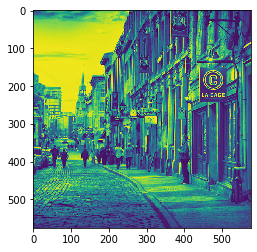

In [0]:
# Save the image in a variable and convert it to grayscale , then show the image 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from skimage import color
from skimage import io
import cv2
  
# Read Images 
img = cv2.imread('lacage.jpg') 


img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
  
# Output Images 
plt.imshow(img)  

# **DCT Encoder:**

**8x8 Block size Part:**

In [0]:
# Divide the image into 8x8 picxels
# The input is the grayscale squared image, the output is an array of blocks each of them is of size 8x8

def Divide_8(img):
  A =  np.asarray(img)
  block = []   

  r = A.shape[0]
  c = A.shape[1]

  for i in range(0,r-7,8):
      for j in range(0,c-7,8):
          block.append(A[i:i+8,j:j+8]); 
  
  block = np.asarray(block)
         
  return block

In [0]:
# Apply the DCT on each 8x8 block
# the input is the block or size 8x8 , the outer loop limits ( limits of row and columns)
# the output is the block after performimg dct 

def ComputeDCT_8(b,u,v):

  Cos_part = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
  Range = [(i,j) for i in range(8) for j in range(8)]

  new_block= 0
  for i,j in Range:
    new_block += b[i][j] * Cos_part[i][u] * Cos_part[j][v]
  if u == 0 and v == 0: new_block = new_block/ 64
  if u == 0 and v!=0: new_block = new_block/ 32
  if u != 0 and v == 0: new_block = new_block / 32
  if u != 0 and v != 0: new_block = new_block / 16
  return new_block    

In [0]:
# Apply the quantization table on 8x8 block (Table 1):
#The input is the block of 8x8 
# The output is the block resulted from dividing the input block by the quantization table
def Quantize8_Table1(block):
   
  table_1 = [[1,1,1,1,1,2,2,4],
            [1,1,1,1,1,2,2,4],
            [1,1,1,1,2,2,2,4],
            [1,1,1,1,2,2,4,8],
            [1,1,2,2,2,2,4,8],
            [2,2,2,2,2,4,8,8],
            [2,2,2,4,4,8,8,16],
            [4,4,4,4,8,8,16,16]]

  table_1 = np.asarray(table_1)
  block =np.asarray(block)
  Q_block = block // table_1
  return (Q_block)

In [0]:
# Apply the quantization table on 8x8 block (Table 2):
#The input is the block of 8x8 
# The output is the block resulted from dividing the input block by the quantization table
def Quantize8_table2(block):
  
  table_2 = [[1,2,4,8,16,32,64,128],
            [2,4,4,8,16,32,64,128],
            [4,4,8,16,32,64,128,128],
            [8,8,16,32,64,128,128,256],
            [16,16,32,64,128,128,256,256],
            [32,32,64,128,128,256,256,256],
            [64,64,128,128,256,256,256,256],
            [128,128,128,256,256,256,256,256]]

  table_2 = np.asarray(table_2)
  block =np.asarray(block)
  Q_block = block // table_2
  return (Q_block)

In [0]:
# convert the 2D block to 1D by zigzag method
# from geeks for geeks : https://www.geeksforgeeks.org/print-matrix-zag-zag-fashion/

def ZigZag(matrix):
  
  matrix = np.asarray(matrix)
  rows = matrix.shape[0]
  columns = matrix.shape[1]
    
  solution=[[] for i in range(rows+columns-1)] 
  
  for i in range(rows): 
      for j in range(columns): 
          sum=i+j 
          if(sum%2 ==0): 
  
            #add at beginning 
              solution[sum].insert(0,matrix[i][j]) 
          else: 
  
            #add at end of the list 
              solution[sum].append(matrix[i][j]) 
          
  
# print the solution as it as 
  u_solution = []
  for i in solution: 
      for j in i: 
          u_solution.append(j)
  
          
  return u_solution          

In [0]:
# Main function for 8x8 block:
# The input is the square image
# The output is 2 vectors of the size of the number of pixcels in the image (one vector represents the the first quantization table division and the other represented 
# the other quantization table division)
#Summary of the algorithm:
# 1.compute the DCT of each block
# 2.compute the quantized block 
# 3.convert the block into a vector by zigzag method
# 4.loop over all the blocks to do the previous processes
# 5.store the small vectors of each block into a big vector

def DCT_encoder_8(I):   # I =  square image
  
  vector_out_1 = []
  vector_out_2 = []
 
  blocks_8 = Divide_8(I)
  
  for b in blocks_8:
    dct_block = [[ComputeDCT_8(b,u,v) for v in range(8)] for u in range(8)]
    dct_block = np.asarray(dct_block)
    block_quantized_1 = Quantize8_Table1(dct_block)
    block_quantized_2 = Quantize8_table2(dct_block)
    final_vector_1 = ZigZag(block_quantized_1)
    final_vector_2 = ZigZag(block_quantized_2)
    vector_out_1.append(final_vector_1)
    vector_out_2.append(final_vector_2)
    
  return vector_out_1,vector_out_2 

**Main code for 8x8 blocks:**

In [0]:
#Call the main function of the encoder then convert the divided vector into a one vector ( stream of integers)

vector1,vector2 = DCT_encoder_8(img)
vector1 = np.asarray(vector1)
vector2=np.asarray(vector2)
vector1_8 = vector1.flatten()
vector2_8 = vector2.flatten()
print(vector1_8)
print(vector2_8)

print(vector1_8.shape)
print(vector2_8.shape)

[74.  3. 15. ...  0. -1. -1.]
[74.  1.  7. ...  0. -1. -1.]
(331776,)
(331776,)


**16 X 16 Block size Part:**

In [0]:
# Divide the image into 16x16 picxels
# the input is the squared grayscale image
# the out put is an array of blocks each of size 8x8

def Divide_16(img):
  A =  np.asarray(img)
  block = []   

  r = A.shape[0]
  c = A.shape[1]
  for i in range(0,r-15,16):
      for j in range(0,c-15,16):
          block.append(A[i:i+16,j:j+16]); 
  
  block = np.asarray(block)       
  return block

In [0]:
# Apply the DCT on each 16x16 block
# the input is the block or size 8x8 , the outer loop limits ( limits of row and columns)
# the output is the block after performimg dct 


def ComputeDCT_16(b,u,v):
  Cos_part = [[math.cos((2*i+1)*j * math.pi/32) for j in range(16)] for i in range(16)]
  Range = [(i,j) for i in range(16) for j in range(16)]

  new_block= 0
  for i,j in Range:
    new_block += b[i][j] * Cos_part[i][u] * Cos_part[j][v]
  if u == 0 and v == 0: new_block = new_block/ 64
  if u == 0 and v!=0: new_block = new_block/ 32
  if u != 0 and v == 0: new_block = new_block / 32
  if u != 0 and v != 0: new_block = new_block / 16
  return new_block  

In [0]:
# Apply the quantization table on 16x16 block (Table 1):
#The input is the block of 16x16
# The output is the block resulted from dividing the input block by the quantization table
def Quantize16_Table1(block):
  
  b = [[1,1,1,1,1,2,2,4],
      [1,1,1,1,1,2,2,4],
      [1,1,1,1,2,2,2,4],
      [1,1,1,1,2,2,4,8],
      [1,1,2,2,2,2,4,8],
      [2,2,2,2,2,4,8,8],
      [2,2,2,4,4,8,8,16],
      [4,4,4,4,8,8,16,16]]
      
  o = np.repeat(b,2,axis=1)
  table_1 = np.repeat(o,2,axis=0)
  table_1 = np.asarray(table_1)
  block =np.asarray(block)

  Q_block = block // table_1
  return Q_block

In [0]:
# Apply the quantization table on 16x16 block (Table 2):
#The input is the block of 16x16
# The output is the block resulted from dividing the input block by the quantization table
def Quantize16_table2(block):
  b = [[1,2,4,8,16,32,64,128],
      [2,4,4,8,16,32,64,128],
      [4,4,8,16,32,64,128,128],
      [8,8,16,32,64,128,128,256],
      [16,16,32,64,128,128,256,256],
      [32,32,64,128,128,256,256,256],
      [64,64,128,128,256,256,256,256],
      [128,128,128,256,256,256,256,256]]      


  o = np.repeat(b,2,axis=1)
  table_2 = np.repeat(o,2,axis=0)
  table_2 = np.asarray(table_2)
  block =np.asarray(block)

  Q_block = block // table_2
  return Q_block

In [0]:
# main function for 16x16 block:
# The input is the square image
# The output is 2 vectors of the size of the number of pixcels in the image (one vector represents the the first quantization table division and the other represented 
# the other quantization table division)
#Summary of the algorithm:
# 1.compute the DCT of each block
# 2.compute the quantized block 
# 3.convert the block into a vector by zigzag method
# 4.loop over all the blocks to do the previous processes
# 5.store the small vectors of each block into a big vector

def DCT_encoder_16(I):   # I =  square image
  
  vector_out_1 = []
  vector_out_2 = []
 
  blocks_16 = Divide_16(I)
  for b in blocks_16:
    
    dct_block = [[ComputeDCT_16(b,u,v) for v in range(16)] for u in range(16)]
    dct_block = np.asarray(dct_block)
    block_quantized_1 = Quantize16_Table1(dct_block)
    block_quantized_2 = Quantize16_table2(dct_block)
    final_vector_1 = ZigZag(block_quantized_1)
    final_vector_2 = ZigZag(block_quantized_2)
    vector_out_1.append(final_vector_1)
    vector_out_2.append(final_vector_2)
    
  return vector_out_1,vector_out_2

**Main code for 16x16 blocks:**

In [0]:
# call the main function of the 16x16 DCT encoder and print the two output vectors
vector1,vector2 = DCT_encoder_16(img)
vector1 = np.asarray(vector1)
vector2 =np.asarray(vector2)
vector1_16 = vector1.flatten()
vector2_16 = vector2.flatten()
print(vector1_16)
print(vector2_16)
print(vector1_16.shape)

[347.  12. -91. ...   0.   0.  -1.]
[347.  12. -91. ...   0.   0.  -1.]
(331776,)


**RunLength Encoder**

In [0]:
 import math
import numpy as np 
 count=0
w=[]
ind=0
for i in vector1_16 : ####Change this when need to change the dct type
 # print(count)
  ind+=1

  if (i==0):
      count+=1
     
      if  (count==1) : #To append the zero only once
         w.append(0)
      if (ind==len(vector1_16)):   ####Change this also
      
        w.append(count)
     

      
  else :
    if (count==0):
      w.append(i)
    else :
         
          w.append(count)
          count=0
          w.append(i)

  
print(w)
    
      
      
      
    
    
    
    
     
  
  

[347.0, 12.0, -91.0, 84.0, 1.0, 4.0, 1.0, 1.0, 23.0, -2.0, 22.0, 16.0, -4.0, 7.0, 2.0, 0, 1, -1.0, 2.0, 0, 1, -4.0, 4.0, -8.0, 9.0, -3.0, 0, 5, -2.0, -3.0, -1.0, -7.0, -2.0, 6.0, 0, 1, 2.0, -8.0, 1.0, -9.0, -2.0, 0, 2, -1.0, 0, 1, -1.0, 0, 2, -1.0, -1.0, -3.0, -5.0, -3.0, -5.0, -2.0, 0, 1, -6.0, -2.0, -1.0, -2.0, 0, 1, -3.0, 1.0, -1.0, 0, 1, -1.0, 0, 2, -1.0, 0, 1, 1.0, -2.0, 0, 1, -1.0, -1.0, -2.0, 1.0, -1.0, 0, 1, -1.0, 0, 3, -1.0, 0, 3, -1.0, -1.0, -1.0, 0, 1, -1.0, -1.0, 0, 1, -1.0, -1.0, 0, 1, -1.0, 1.0, -1.0, 0, 1, -1.0, 0, 1, -1.0, -1.0, 0, 1, -1.0, 0, 2, -1.0, -1.0, 0, 1, -1.0, 0, 2, -1.0, -1.0, 0, 5, -1.0, -1.0, 0, 3, -1.0, 0, 1, -1.0, 0, 1, -1.0, 0, 1, -1.0, -1.0, 0, 2, -1.0, -1.0, 0, 1, -1.0, -1.0, 0, 1, -1.0, 0, 2, -1.0, -1.0, -1.0, -1.0, 0, 2, -1.0, -1.0, 0, 1, -1.0, -1.0, -1.0, -1.0, -1.0, 0, 1, -1.0, 0, 1, -1.0, 0, 2, -1.0, -1.0, -1.0, -1.0, 0, 1, -1.0, 0, 1, -1.0, -1.0, 0, 1, -1.0, -1.0, 0, 4, -1.0, 0, 2, -1.0, 0, 1, -1.0, 0, 1, -1.0, 0, 8, -1.0, 0, 1, -1.0, -1.0, 0, 1,

**To extract RunLength Output array to try Huffman on Matlab**

In [0]:
import scipy.io
from collections import Counter
a=np.asarray(vector2_8)
#To have the unique elements in an array and their repeatition in a parallel array
b=Counter(vector2_8)
G=list(b.values()) 
o=list(b.keys())
print(b)
print(G)   
print(len(o))
scipy.io.savemat('Repeations.mat', dict(x=G))
scipy.io.savemat('Values.mat', dict(x=o))
scipy.io.savemat('BitsStreem.mat',dict(x=a))

Counter({0.0: 148931, -1.0: 147757, 1.0: 5814, -2.0: 5783, 2.0: 2513, -3.0: 2469, -4.0: 1692, 3.0: 1648, 4.0: 999, -5.0: 967, -6.0: 731, 5.0: 674, -7.0: 529, 6.0: 518, -8.0: 499, 7.0: 447, 8.0: 357, -9.0: 345, -10.0: 272, 9.0: 261, 10.0: 258, -11.0: 236, 12.0: 167, -12.0: 163, 11.0: 152, -13.0: 147, 13.0: 144, -14.0: 123, 14.0: 119, -15.0: 110, 15.0: 110, 249.0: 110, 18.0: 91, -16.0: 89, 248.0: 83, 16.0: 81, -17.0: 79, -20.0: 72, 19.0: 71, -19.0: 70, 26.0: 64, 20.0: 63, -18.0: 62, 25.0: 61, -21.0: 60, 17.0: 58, 21.0: 56, 38.0: 51, 22.0: 50, 56.0: 48, 59.0: 48, 77.0: 48, 107.0: 47, 23.0: 46, 40.0: 44, 27.0: 44, 65.0: 43, 32.0: 43, 55.0: 43, 113.0: 42, 83.0: 42, 53.0: 41, 246.0: 41, 116.0: 41, 70.0: 40, 46.0: 40, 140.0: 40, 58.0: 40, 86.0: 40, -22.0: 40, 74.0: 39, 30.0: 39, 98.0: 39, 50.0: 39, 119.0: 39, 68.0: 39, 64.0: 39, 118.0: 39, 52.0: 38, 67.0: 38, 24.0: 38, 92.0: 38, -25.0: 38, -23.0: 38, 139.0: 38, 39.0: 38, 130.0: 38, 62.0: 37, 134.0: 37, 133.0: 37, 71.0: 35, 245.0: 35, 136.0: 3

**ٌRunLength Encoder** 

In [0]:
k=[]
c=0
n=1
W=w.copy() #Just to keep W untouched 
for i in W:
  c+=1
  if (i!=0):
    k.append(i)
  else:
     
     R=W[c]
     for j in range(R):
       k.append(0)
     del W[c]
   
D=np.transpose(k)
D

array([347.,  12., -91., ...,   0.,   0.,  -1.])

In [0]:
##



#                                           **DCT Decoder:**





**IDCT for 8x8 blocks Part:**

In [0]:
# Inverse zigzag function
# the input is the vector of the same size of image pixcels
# from: https://github.com/getsanjeev/compression-DCT/blob/master/zigzag.py
def inverse_zigzag(input, vmax, hmax):
	
	# initializing the variables
	#----------------------------------
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))

	i = 0
    #----------------------------------

	while ((v < vmax) and (h < hmax)): 
		#print ('v:',v,', h:',h,', i:',i)   	
		if ((h + v) % 2) == 0:                 # going up
            
			if (v == vmin):
				#print(1)
				
				output[v, h] = input[i]        # if we got to the first line

				if (h == hmax):
					v = v + 1
				else:
					h = h + 1                        

				i = i + 1

			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				#print(2)
				output[v, h] = input[i] 
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				#print(3)
				output[v, h] = input[i] 
				v = v - 1
				h = h + 1
				i = i + 1

        
		else:                                    # going down

			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				#print(4)
				output[v, h] = input[i] 
				h = h + 1
				i = i + 1
        
			elif (h == hmin):                  # if we got to the first column
				#print(5)
				output[v, h] = input[i] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
        		        		
			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i] 
				v = v + 1
				h = h - 1
				i = i + 1




		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			#print(7)        	
			output[v, h] = input[i] 
			break


	return output


In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 8x8
#the output is a block results from multiply the input block by the quantization table
def inverse_Quantize8_Table1(block):
  table_1 = [[1,1,1,1,1,2,2,4],
            [1,1,1,1,1,2,2,4],
            [1,1,1,1,2,2,2,4],
            [1,1,1,1,2,2,4,8],
            [1,1,2,2,2,2,4,8],
            [2,2,2,2,2,4,8,8],
            [2,2,2,4,4,8,8,16],
            [4,4,4,4,8,8,16,16]]

  table_1 = np.asarray(table_1)
  block =np.asarray(block)

  Q_block = np.multiply(block,table_1)
  return Q_block

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 8x8
#the output is a block results from multiply the input block by the quantization table
def inverse_Quantize8_table2(block):
  table_2 = [[1,2,4,8,16,32,64,128],
            [2,4,4,8,16,32,64,128],
            [4,4,8,16,32,64,128,128],
            [8,8,16,32,64,128,128,256],
            [16,16,32,64,128,128,256,256],
            [32,32,64,128,128,256,256,256],
            [64,64,128,128,256,256,256,256],
            [128,128,128,256,256,256,256,256]]

  table_2 = np.asarray(table_2)
  block =np.asarray(block)

  Q_block = np.multiply(block,table_2)
  return Q_block


In [0]:
# compute the inverse DCT by multiply the block by the corresponding cofficient in the DCT matrix
# the input is the block and the limits of the outer summations ( no.row and no.columns)
# the output is the block after IDCT 
def ComputeIDCT_8(a,i,j):
  Cos_part = [[math.cos((2*i+1)*j * math.pi/16) for j in range(8)] for i in range(8)]
  Range = [(i,j) for i in range(8) for j in range(8)]

  inverse_block = 0

  for u,v in Range:
    block = a[u][v] * Cos_part[i][u] * Cos_part[j][v]
    inverse_block += block
    
  return (np.floor(inverse_block))

In [0]:
# Main function of the decoder 8x8 block size:
# the input is the vector with same size of the original image number of pixcels
# the output is the compressed image
# Summary of Algorithm:
# 1.apply the inverse zigzag to convert the vector into block
# 2.inverse the quantization process
# 3.compute the IDCT of the block
# 4.loop over all the vector to do the previous processes
# 5.store the final blocks in an array
# 6.reconstruct the image from the final array of blocks
def IDCT_driver_8(vector):
  import cv2
  from google.colab.patches import cv2_imshow
  import matplotlib.pyplot as plt
  from PIL import Image

  coded_input1_8 = vector
  coded_input1_8 = coded_input1_8.reshape(5184,64)
  i_final_blocks = []
  for c in coded_input1_8:
    i_blocks8_1 = inverse_zigzag(c, 8, 8)
    i_Qblocks8_1 = inverse_Quantize8_Table1(i_blocks8_1)
    i_dct_blocks8_1 = [[ComputeIDCT_8(i_Qblocks8_1,i,j) for j in range(8)] for i in range(8)] 
    i_final_blocks.append(i_dct_blocks8_1)

  i_final_blocks = np.asarray(i_final_blocks)

  # reconstruct the image:
  a = i_final_blocks

  image = np.zeros((576,576))

  k = 0
  for i in range(0,576,8):
    for j in range(0,576,8):
    
    
      image[i:i+8,j:j+8] = a[k]
    
      k = k+1

  return(image)

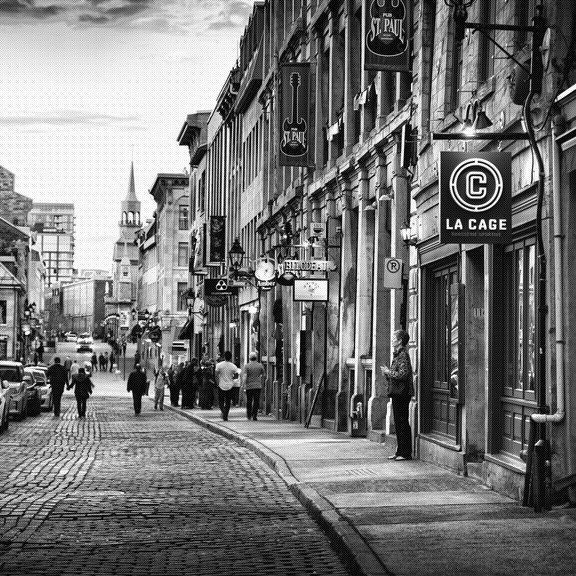

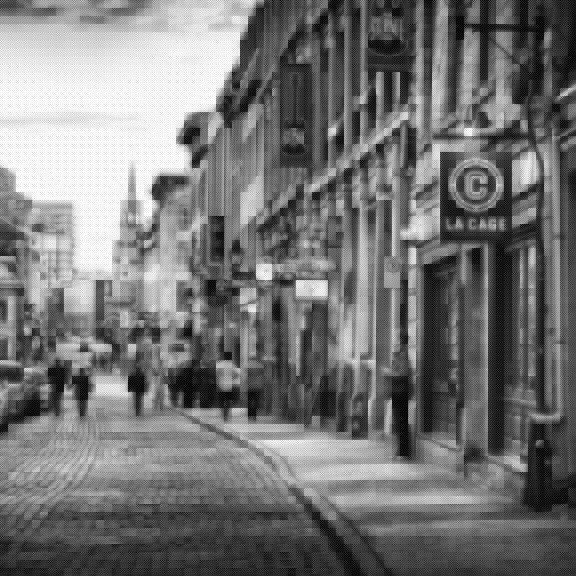

In [0]:
# main code for IDDCT 8x8:
# call the main function for IDCT 8x8 and show the images
import cv2
from google.colab.patches import cv2_imshow
re_image_1 = IDCT_driver_8(vector1_8)
re_image_2 = IDCT_driver_8(vector2_8)

cv2_imshow(re_image_1)
cv2_imshow(re_image_2)

**IDCT for 16x16 block Part:**

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 16x16
#the output is a block results from multiply the input block by the quantization table
# the quantization table here is the same as 8x8 but we extend it to be 16x16 by repeats each row and column one time
def inverse_Quantize16_Table1(block):
  b = [[1,1,1,1,1,2,2,4],
         [1,1,1,1,1,2,2,4],
         [1,1,1,1,2,2,2,4],
         [1,1,1,1,2,2,4,8],
         [1,1,2,2,2,2,4,8],
         [2,2,2,2,2,4,8,8],
         [2,2,2,4,4,8,8,16],
         [4,4,4,4,8,8,16,16]]


  o = np.repeat(b,2,axis=1)
  table_1 = np.repeat(o,2,axis=0)
  table_1 = np.asarray(table_1)
  block =np.asarray(block)
  Q_block = np.multiply(block,table_1)
  return Q_block

In [0]:
# function to inverse the quantization process we made in the encoder
# the input is the block of size 16x16
#the output is a block results from multiply the input block by the quantization table
# the quantization table here is the same as 8x8 but we extend it to be 16x16 by repeats each row and column one time
def inverse_Quantize16_table2(block):
  b = [[1,2,4,8,16,32,64,128],
      [2,4,4,8,16,32,64,128],
      [4,4,8,16,32,64,128,128],
      [8,8,16,32,64,128,128,256],
      [16,16,32,64,128,128,256,256],
      [32,32,64,128,128,256,256,256],
      [64,64,128,128,256,256,256,256],
      [128,128,128,256,256,256,256,256]]


  o = np.repeat(b,2,axis=1)
  table_2 = np.repeat(o,2,axis=0)
  table_2 = np.asarray(table_2)
  block =np.asarray(block)
  Q_block = np.multiply(block, table_2)
  return Q_block

In [0]:
# compute the inverse DCT by multiply the block by the corresponding cofficient in the DCT matrix
# the input is the block and the limits of the outer summations ( no.row and no.columns)
# the output is the block after IDCT 
def ComputeIDCT_16(a,i,j):
  Cos_part = [[math.cos((2*i+1)*j * math.pi/32) for j in range(16)] for i in range(16)]
  Range = [(i,j) for i in range(16) for j in range(16)]

  inverse_block = 0

  for u,v in Range:
    block = a[u][v] * Cos_part[i][u] * Cos_part[j][v]
    inverse_block += block


  inverse_block = inverse_block * 0.25
  return (np.floor(inverse_block))

In [0]:
# main function for IDCT 16x16
# Main function of the decoder 8x8 block size:
# the input is the vector with same size of the original image number of pixcels
# the output is the compressed image
# Summary of Algorithm:
# 1.apply the inverse zigzag to convert the vector into block
# 2.inverse the quantization process
# 3.compute the IDCT of the block
# 4.loop over all the vector to do the previous processes
# 5.store the final blocks in an array
# 6.reconstruct the image from the final array of blocks
def IDCT_driver_16(vector):
  import cv2
  from google.colab.patches import cv2_imshow
  import matplotlib.pyplot as plt
  from PIL import Image

  coded_input1_16 = vector
  coded_input1_16 = coded_input1_16.reshape(1296,256)
  i_final_blocks = []
  for c in coded_input1_16:
    i_blocks16_1 = inverse_zigzag(c, 16, 16)
    i_Qblocks16_1 = inverse_Quantize16_Table1(i_blocks16_1)
    i_dct_blocks16_1 = [[ComputeIDCT_16(i_Qblocks16_1,i,j) for j in range(16)] for i in range(16)] 
    i_final_blocks.append(i_dct_blocks16_1)

  i_final_blocks = np.asarray(i_final_blocks)
  
  # reconstruct the image:
  a = i_final_blocks

  image = np.zeros((576,576))

  k = 0
  for i in range(0,576,16):
    for j in range(0,576,16):
    
    
      image[i:i+16,j:j+16] = a[k]
    
      k = k+1

  
  return(image)

**Main code for IDCT 16x16 blocks:**

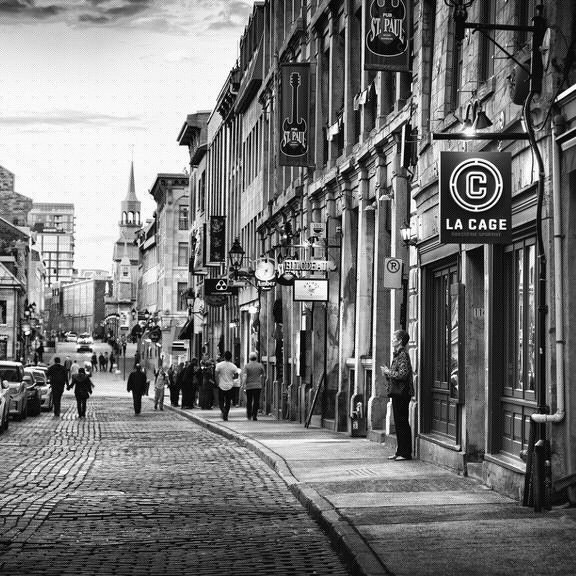

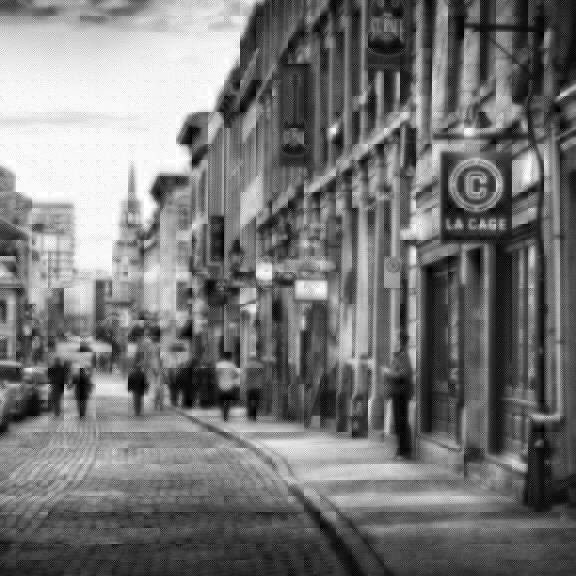

In [0]:
# main code for IDDCT 16x16:
# call the main function for IDCT 16x16 and show the images
import cv2
from google.colab.patches import cv2_imshow
re_image_3 = IDCT_driver_16(vector1_16)
re_image_4 = IDCT_driver_16(vector2_16)
cv2_imshow(re_image_3)
cv2_imshow(re_image_4)

In [0]:
# calculate the MSE:
import numpy as np
def Calc_MSE(I_original,I_compressed):

  difference = I_original - I_compressed
  square_diff = difference**2
  square_diff = np.matrix(square_diff)
  summer = square_diff.sum()
  MSE = summer/(576*576)

  return MSE


# Image 8x8 table 1:
MSE_1 = Calc_MSE(img,re_image_1)
print('Image 1',MSE_1)

# Image 8x8 table 2 :
MSE_2 = Calc_MSE(img,re_image_2)
print('Image 2',MSE_2)

# Image 16x16 table 1 :
MSE_3 = Calc_MSE(img,re_image_3)
print('Image 3',MSE_3)

# Image 16x16 table 2:
MSE_4 = Calc_MSE(img,re_image_4)
print('Image 4',MSE_4)


Image 1 197.964656876929
Image 2 1080.002212336034
Image 3 42.71117862654321
Image 4 894.5382245852624
